In [35]:
import numpy as np
import pandas as pd

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [37]:
import seaborn as sns

# Циклостационарность

In [72]:
def get_slice(seq, col_id):
    seq_len_orig = seq.assign(cnt=1).groupby(col_id)['cnt'].sum().sort_index().values
    s_max_sample_len = np.clip(seq_len_orig.clip(0, max_len) - min_len, 0, None)
    s_len = (s_max_sample_len * np.random.rand(len(seq_len_orig))).astype(int) + min_len
    s_avl_pos = np.clip(seq_len_orig - s_len, 0, None)
    s_start = (s_avl_pos * np.random.rand(len(seq_len_orig))).astype(int)

    ixs = np.concatenate([(np.arange(cn) >= st) & (np.arange(cn) <= st + ln)
        for (cn, st, ln) in zip(seq_len_orig, s_start, s_len)])

    return seq.iloc[ixs]


In [64]:
def kl_distribution(a, b):
    common_index = a.columns.union(b.columns)

    a = a.reindex(columns=common_index).fillna(0)
    b = b.reindex(columns=common_index).fillna(0)

    a = a.values
    b = b.values

    return np.where(a == 0, 0.0, a * np.log(np.where(a == 0, 1e-12, a) / np.where(b == 0, 1e-12, b))).sum(axis=1)

## Age Group

In [38]:
df_trx = pd.concat([
    pd.read_csv('pycharm-deploy/pytorch-lifestream/experiments/scenario_age_pred/data/transactions_train.csv'),
    pd.read_csv('pycharm-deploy/pytorch-lifestream/experiments/scenario_age_pred/data/transactions_test.csv'),
], axis=0)

In [39]:
df_trx = df_trx.sort_values(['client_id', 'trans_date'])

In [40]:
df_slices = df_trx.assign(cnt=1).groupby('client_id')[['cnt']].sum().sort_index()

In [41]:
min_len, max_len = 25, 200

In [57]:
seq_len_orig = df_slices['cnt'].values
disjoint_split_point = np.where(
    seq_len_orig > 2 * min_len,
    (np.random.rand(len(seq_len_orig)) * (seq_len_orig - 2 * min_len)).astype(int) + min_len,
    (seq_len_orig / 2).astype(int),
)

ixs = np.concatenate([(np.arange(cn) < st) for cn, st in zip(seq_len_orig, disjoint_split_point)])
seq_a = df_trx.iloc[ixs]

ixs = np.concatenate([(np.arange(cn) >= st) for cn, st in zip(seq_len_orig, disjoint_split_point)])
seq_b = df_trx.iloc[ixs]

In [59]:
seq_a = get_slice(seq_a, 'client_id')
seq_b = get_slice(seq_b, 'client_id')

In [60]:
seq_a = seq_a.pivot_table(index='client_id', columns='small_group', values='amount_rur', aggfunc=len).fillna(0)
seq_a = seq_a.div(seq_a.sum(axis=1), axis=0)

In [61]:
seq_b = seq_b.pivot_table(index='client_id', columns='small_group', values='amount_rur', aggfunc=len).fillna(0)
seq_b = seq_b.div(seq_b.sum(axis=1), axis=0)

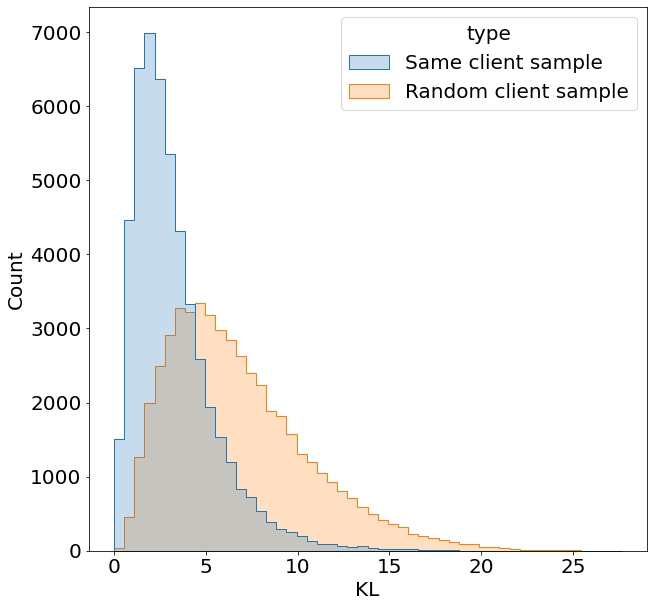

In [65]:
ix_shuffle = np.random.choice(len(seq_a), len(seq_a), replace=False)

with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(10, 10))
    mpl.rc('font', size=20)

    sns.histplot(pd.concat([
        pd.DataFrame({'KL': kl_distribution(seq_a, seq_b).clip(0, None),
                      'type': 'Same client sample'}),
        pd.DataFrame({'KL': kl_distribution(seq_a, seq_b.iloc[ix_shuffle]).clip(0, None), 
                      'type': 'Random client sample'}),
    ], axis=0), x="KL", hue="type", bins=50, element='step')

    # plt.title('Age group')
    mpl.pyplot.savefig('kl_dis_age_group.pdf', format='pdf', bbox_inches='tight')
    # plt.show()

## Churn

In [81]:
df_trx = pd.concat([
    pd.read_csv('pycharm-deploy/pytorch-lifestream/experiments/scenario_rosbank/data/train.csv'),
    pd.read_csv('pycharm-deploy/pytorch-lifestream/experiments/scenario_rosbank/data/test.csv'),
], axis=0)

In [82]:
df_trx

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0.0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0.0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0.0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0.0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
518371,01/04/2017,10135,5074,type1,810,17APR17:00:00:00,6133.6,POS,NaN,NaN
518372,01/03/2017,10135,5912,type1,810,10MAR17:00:00:00,394.5,POS,NaN,NaN
518373,01/05/2017,10135,5541,type1,810,01MAY17:00:00:00,1813.5,POS,NaN,NaN
518374,01/03/2017,10135,5912,type1,810,16MAR17:00:00:00,569.3,POS,NaN,NaN


In [83]:
df_trx['PERIOD'] = pd.to_datetime(df_trx['PERIOD'], format='%d/%m/%Y')

In [84]:
df_trx = df_trx.sort_values(['cl_id', 'PERIOD', 'TRDATETIME'])

In [98]:
df_slices = df_trx.assign(cnt=1).groupby('cl_id')[['cnt']].sum().sort_index()

In [100]:
df_slices = df_slices[lambda x: x['cnt'] > 10]
df_trx = df_trx[lambda x: x['cl_id'].isin(df_slices.index)]

In [101]:
min_len, max_len = 15, 150

In [102]:
seq_len_orig = df_slices['cnt'].values
disjoint_split_point = np.where(
    seq_len_orig > 2 * min_len,
    (np.random.rand(len(seq_len_orig)) * (seq_len_orig - 2 * min_len)).astype(int) + min_len,
    (seq_len_orig / 2).astype(int),
)

ixs = np.concatenate([(np.arange(cn) < st) for cn, st in zip(seq_len_orig, disjoint_split_point)])
seq_a = df_trx.iloc[ixs]

ixs = np.concatenate([(np.arange(cn) >= st) for cn, st in zip(seq_len_orig, disjoint_split_point)])
seq_b = df_trx.iloc[ixs]

In [103]:
seq_a = get_slice(seq_a, 'cl_id')
seq_b = get_slice(seq_b, 'cl_id')

In [104]:
seq_a = seq_a.pivot_table(index='cl_id', columns='MCC', values='amount', aggfunc=len).fillna(0)
seq_a = seq_a.div(seq_a.sum(axis=1), axis=0)

In [105]:
seq_b = seq_b.pivot_table(index='cl_id', columns='MCC', values='amount', aggfunc=len).fillna(0)
seq_b = seq_b.div(seq_b.sum(axis=1), axis=0)

In [106]:
len(seq_a), len(seq_b)

(9360, 9360)

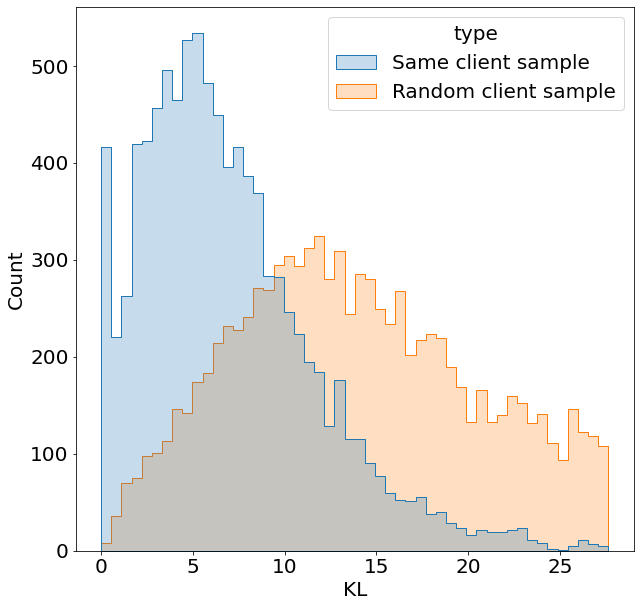

In [107]:
ix_shuffle = np.random.choice(len(seq_a), len(seq_a), replace=False)

with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(10, 10))
    mpl.rc('font', size=20)

    sns.histplot(pd.concat([
        pd.DataFrame({'KL': kl_distribution(seq_a, seq_b).clip(0, None),
                      'type': 'Same client sample'}),
        pd.DataFrame({'KL': kl_distribution(seq_a, seq_b.iloc[ix_shuffle]).clip(0, None), 
                      'type': 'Random client sample'}),
    ], axis=0), x="KL", hue="type", bins=50, element='step')

    # plt.title('Age group')
    mpl.pyplot.savefig('kl_dis_churn.pdf', format='pdf', bbox_inches='tight')
    # plt.show()

## Assessment

In [156]:
df_trx = pd.concat([
    pd.read_csv('pycharm-deploy/pytorch-lifestream/experiments/scenario_bowl2019/data/train.csv'),
    pd.read_csv('pycharm-deploy/pytorch-lifestream/experiments/scenario_bowl2019/data/test.csv'),
], axis=0)

In [157]:
df_trx.head(2)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,event_type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK


In [158]:
df_trx = df_trx.sort_values(['game_session', 'timestamp'])

In [163]:
df_slices = df_trx.assign(cnt=1).groupby('game_session')[['cnt']].sum().sort_index()

In [164]:
df_slices = df_slices[lambda x: x['cnt'] > 10]
df_trx = df_trx[lambda x: x['game_session'].isin(df_slices.index)]

In [165]:
min_len, max_len = 100, 500

In [171]:
seq_len_orig = df_slices['cnt'].values
disjoint_split_point = np.where(
    seq_len_orig > 2 * min_len,
    (np.random.rand(len(seq_len_orig)) * (seq_len_orig - 2 * min_len)).astype(int) + min_len,
    (seq_len_orig / 2).astype(int),
)

ixs = np.concatenate([(np.arange(cn) < st) for cn, st in zip(seq_len_orig, disjoint_split_point)])
seq_a = df_trx.iloc[ixs]

ixs = np.concatenate([(np.arange(cn) >= st) for cn, st in zip(seq_len_orig, disjoint_split_point)])
seq_b = df_trx.iloc[ixs]

In [172]:
seq_a = get_slice(seq_a, 'game_session')
seq_b = get_slice(seq_b, 'game_session')

In [173]:
seq_a = seq_a.pivot_table(index='game_session', columns='event_code', values='title', aggfunc=len).fillna(0)
seq_a = seq_a.div(seq_a.sum(axis=1), axis=0)

In [174]:
seq_b = seq_b.pivot_table(index='game_session', columns='event_code', values='title', aggfunc=len).fillna(0)
seq_b = seq_b.div(seq_b.sum(axis=1), axis=0)

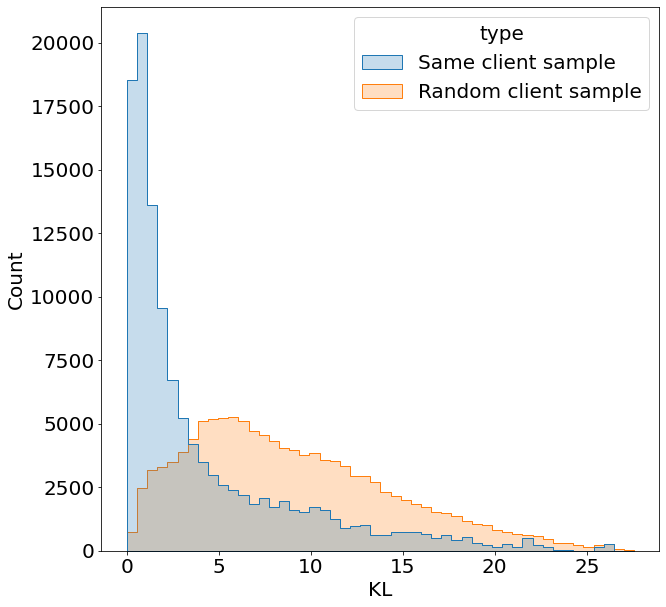

In [175]:
ix_shuffle = np.random.choice(len(seq_a), len(seq_a), replace=False)

with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(10, 10))
    mpl.rc('font', size=20)

    sns.histplot(pd.concat([
        pd.DataFrame({'KL': kl_distribution(seq_a, seq_b).clip(0, None),
                      'type': 'Same client sample'}),
        pd.DataFrame({'KL': kl_distribution(seq_a, seq_b.iloc[ix_shuffle]).clip(0, None), 
                      'type': 'Random client sample'}),
    ], axis=0), x="KL", hue="type", bins=50, element='step')

    # plt.title('Age group')
    mpl.pyplot.savefig('kl_dis_assessment.pdf', format='pdf', bbox_inches='tight')
    # plt.show()

## X5

In [122]:
df_trx = pd.read_csv('pycharm-deploy/pytorch-lifestream/experiments/scenario_x5/data/purchases.csv')

In [123]:
df_products = pd.read_csv('pycharm-deploy/pytorch-lifestream/experiments/scenario_x5/data/products.csv')

In [124]:
df_trx = pd.merge(df_trx, df_products[['product_id', 'level_3', 'level_4']])

In [125]:
df_trx.head(2)

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red,level_3,level_4
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.00,54a4a11a29,9a80204f78,2.0,80.0,NaN,b25baa9dd5,51647c28e9
1,0003b55871,755ee5d934,2019-02-25 16:26:51,17.7,0.0,0.0,0.0,1770.38,b2ebbbc616,9a80204f78,1.0,45.0,NaN,b25baa9dd5,51647c28e9


In [126]:
df_trx = df_trx.sort_values(['client_id', 'transaction_datetime'])

In [127]:
df_slices = df_trx.assign(cnt=1).groupby('client_id')[['cnt']].sum().sort_index()
df_slices = df_slices[lambda x: x['cnt'] > 10]
df_trx = df_trx[lambda x: x['client_id'].isin(df_slices.index)]

In [128]:
min_len, max_len = 30, 180

In [129]:
seq_len_orig = df_slices['cnt'].values
disjoint_split_point = np.where(
    seq_len_orig > 2 * min_len,
    (np.random.rand(len(seq_len_orig)) * (seq_len_orig - 2 * min_len)).astype(int) + min_len,
    (seq_len_orig / 2).astype(int),
)

ixs = np.concatenate([(np.arange(cn) < st) for cn, st in zip(seq_len_orig, disjoint_split_point)])
seq_a = df_trx.iloc[ixs]

ixs = np.concatenate([(np.arange(cn) >= st) for cn, st in zip(seq_len_orig, disjoint_split_point)])
seq_b = df_trx.iloc[ixs]

In [130]:
seq_a = get_slice(seq_a, 'client_id')
seq_b = get_slice(seq_b, 'client_id')

In [131]:
seq_a = seq_a.pivot_table(index='client_id', columns='level_3', values='level_4', aggfunc=len).fillna(0)
seq_a = seq_a.div(seq_a.sum(axis=1), axis=0)

In [132]:
seq_b = seq_b.pivot_table(index='client_id', columns='level_3', values='level_4', aggfunc=len).fillna(0)
seq_b = seq_b.div(seq_b.sum(axis=1), axis=0)

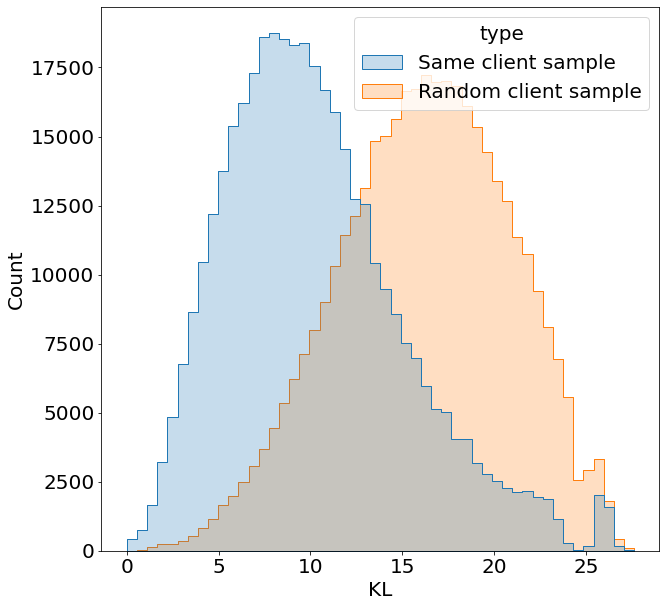

In [133]:
ix_shuffle = np.random.choice(len(seq_a), len(seq_a), replace=False)

with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(10, 10))
    mpl.rc('font', size=20)

    sns.histplot(pd.concat([
        pd.DataFrame({'KL': kl_distribution(seq_a, seq_b).clip(0, None),
                      'type': 'Same client sample'}),
        pd.DataFrame({'KL': kl_distribution(seq_a, seq_b.iloc[ix_shuffle]).clip(0, None), 
                      'type': 'Random client sample'}),
    ], axis=0), x="KL", hue="type", bins=50, element='step')

    # plt.title('Age group')
    mpl.pyplot.savefig('kl_dis_retail.pdf', format='pdf', bbox_inches='tight')
    # plt.show()